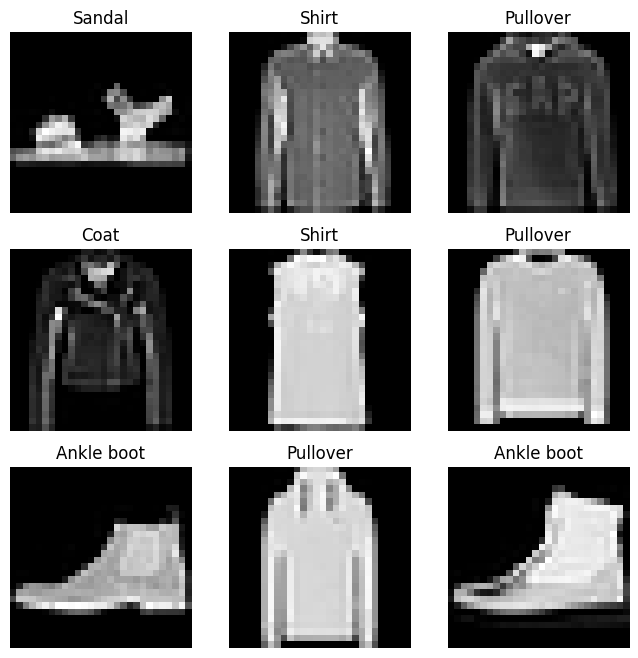

In [32]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision.io import read_image


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

labels_map  = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [65]:

import os
import pandas as pd
from torchvision.io import read_image
# torch.utils.data.Dataset을 상속받아 직접 커스텀 데이터셋 만들어보자
class CustomDataset(Dataset):
    # 데이터를 전처리 해주는 부분
    def __init__(self, data, transforms=None):
        self.data = data
        self.transforms = transforms

    # 데이터셋의 길이 즉 샘플의 수를 적어주는 부분
    def __len__(self):
        return len(self.data)
    #데이터셋에서 특정 1개의 샘플을 가져오는 함수
    def __getitem__(self,index):
        sample = self.data[index]
        if self.transforms:
            sample = self.transforms(sample)
        return sample


training_dataset = CustomDataset(training_data)
test_dataset = CustomDataset(test_data)

from torch.utils.data import DataLoader

training_loader = DataLoader(training_dataset, batch_size=64, shuffle=True)
test_laoder = DataLoader(test_dataset,batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


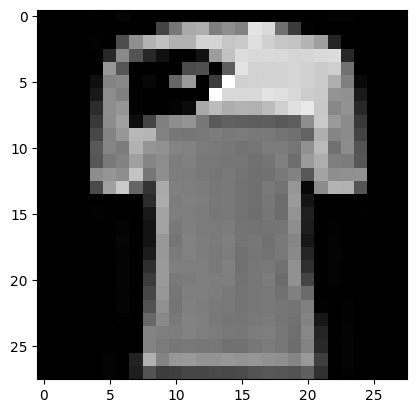

Label: 0


In [38]:
train_features, train_labels = next(iter(training_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [10]:
# 모델 만들기
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cpu device


In [58]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(28*28,512),
        nn.ReLU(),
        nn.Linear(512,512),
        nn.ReLU(),
        nn.Linear(512,10),
        nn.ReLU()

    )

  def forward(self,x):
      x = self.flatten(x)
      logits = self.linear_relu_stack(x)
      return logits

In [50]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


In [59]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

In [60]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [61]:
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
      test_loss /= num_batches
  print(f"Test Error: \n Accuracy: {(100*correct/size):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [62]:
epochs = 5
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train(training_loader, model, loss_fn, optimizer)
  test(test_laoder, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.293320  [    0/60000]
loss: 2.227611  [ 6400/60000]
loss: 2.050948  [12800/60000]
loss: 1.857251  [19200/60000]
loss: 1.624937  [25600/60000]
loss: 1.614772  [32000/60000]
loss: 1.507129  [38400/60000]
loss: 1.383574  [44800/60000]
loss: 1.310523  [51200/60000]
loss: 1.172936  [57600/60000]
Test Error: 
 Accuracy: 60.9%, Avg loss: 0.008294 

Epoch 2
-------------------------------
loss: 1.174616  [    0/60000]
loss: 1.238735  [ 6400/60000]
loss: 1.361909  [12800/60000]
loss: 1.041786  [19200/60000]
loss: 0.981203  [25600/60000]
loss: 1.108875  [32000/60000]
loss: 0.912218  [38400/60000]
loss: 1.265267  [44800/60000]
loss: 1.171473  [51200/60000]
loss: 1.359085  [57600/60000]
Test Error: 
 Accuracy: 66.4%, Avg loss: 0.007656 

Epoch 3
-------------------------------
loss: 1.231696  [    0/60000]
loss: 0.916984  [ 6400/60000]
loss: 1.054032  [12800/60000]
loss: 0.936825  [19200/60000]
loss: 1.101298  [25600/60000]
loss: 1.366316  [32000/600

In [64]:
model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = labels_map[pred[0].argmax(0)], labels_map[y]
    print(f'Predicted: "{predicted}, Actaul: {actual}"')

Predicted: "Ankle boot, Actaul: Ankle boot"
